## Scenario - Robots in a Warehouse
A growing e-commerce company is building a new warehouse, and the company would like all of the picking operations in the new warehouse to be performed by warehouse robots.
* In the context of e-commerce warehousing, “picking” is the task of gathering individual items from various locations in the warehouse in order to fulfill customer orders.

After picking items from the shelves, the robots must bring the items to a specific location within the warehouse where the items can be packaged for shipping.

In order to ensure maximum efficiency and productivity, the robots will need to learn the shortest path between the item packaging area and all other locations within the warehouse where the robots are allowed to travel.
* We will use Q-learning to accomplish this task!

#### Import Required Libraries

In [1]:
#import libraries
import numpy as np

## Define the Environment
The environment consists of **states**, **actions**, and **rewards**. States and actions are inputs for the Q-learning AI agent, while the possible actions are the AI agent's outputs.
#### States
The states in the environment are all of the possible locations within the warehouse. Some of these locations are for storing items (**black squares**), while other locations are aisles that the robot can use to travel throughout the warehouse (**white squares**). The **green square** indicates the item packaging and shipping area.

The black and green squares are **terminal states**!

![warehouse map](https://www.danielsoper.com/teaching/img/08-warehouse-map.png)

The AI agent's goal is to learn the shortest path between the item packaging area and all of the other locations in the warehouse where the robot is allowed to travel.

As shown in the image above, there are 121 possible states (locations) within the warehouse. These states are arranged in a grid containing 11 rows and 11 columns. Each location can hence be identified by its row and column index.

In [2]:
#define the shape of the environment (i.e., its states)
environment_rows = 11
environment_columns = 11

#Create a 3D numpy array to hold the current Q-values for each state and action pair: Q(s, a)
#The array contains 11 rows and 11 columns (to match the shape of the environment), as well as a third "action" dimension.
#The "action" dimension consists of 4 layers that will allow us to keep track of the Q-values for each possible action in
#each state (see next cell for a description of possible actions).
#The value of each (state, action) pair is initialized to 0.
q_values = np.zeros((environment_rows, environment_columns, 4)) 
print(q_values,np.shape(q_values))
#environment_rows determines which row (0-10) of the possible states(locations) of the warehouse
#environment_columns determines which row (0-10) of the possible states(locations) of the warehouse
#4 which of the four actions 0=Up/1=Right/2=Down/3=Left is taken
#So e.g. q_values(2,3,2) => Q-value obtained of being in row 2, column 3 of the warehouse and taking "Down" action
#test = np.zeros((2,3,4))
#print(test)
#np.shape(test)

[[[0. 0. 0. 0.]
  [0. 0. 0. 0.]
  [0. 0. 0. 0.]
  [0. 0. 0. 0.]
  [0. 0. 0. 0.]
  [0. 0. 0. 0.]
  [0. 0. 0. 0.]
  [0. 0. 0. 0.]
  [0. 0. 0. 0.]
  [0. 0. 0. 0.]
  [0. 0. 0. 0.]]

 [[0. 0. 0. 0.]
  [0. 0. 0. 0.]
  [0. 0. 0. 0.]
  [0. 0. 0. 0.]
  [0. 0. 0. 0.]
  [0. 0. 0. 0.]
  [0. 0. 0. 0.]
  [0. 0. 0. 0.]
  [0. 0. 0. 0.]
  [0. 0. 0. 0.]
  [0. 0. 0. 0.]]

 [[0. 0. 0. 0.]
  [0. 0. 0. 0.]
  [0. 0. 0. 0.]
  [0. 0. 0. 0.]
  [0. 0. 0. 0.]
  [0. 0. 0. 0.]
  [0. 0. 0. 0.]
  [0. 0. 0. 0.]
  [0. 0. 0. 0.]
  [0. 0. 0. 0.]
  [0. 0. 0. 0.]]

 [[0. 0. 0. 0.]
  [0. 0. 0. 0.]
  [0. 0. 0. 0.]
  [0. 0. 0. 0.]
  [0. 0. 0. 0.]
  [0. 0. 0. 0.]
  [0. 0. 0. 0.]
  [0. 0. 0. 0.]
  [0. 0. 0. 0.]
  [0. 0. 0. 0.]
  [0. 0. 0. 0.]]

 [[0. 0. 0. 0.]
  [0. 0. 0. 0.]
  [0. 0. 0. 0.]
  [0. 0. 0. 0.]
  [0. 0. 0. 0.]
  [0. 0. 0. 0.]
  [0. 0. 0. 0.]
  [0. 0. 0. 0.]
  [0. 0. 0. 0.]
  [0. 0. 0. 0.]
  [0. 0. 0. 0.]]

 [[0. 0. 0. 0.]
  [0. 0. 0. 0.]
  [0. 0. 0. 0.]
  [0. 0. 0. 0.]
  [0. 0. 0. 0.]
  [0. 0. 0. 0.]
  [0. 0. 0. 0.

#### Actions
The actions that are available to the AI agent are to move the robot in one of four directions:
* Up
* Right
* Down
* Left

Obviously, the AI agent must learn to avoid driving into the item storage locations (e.g., shelves)!


In [3]:
#define actions
#numeric action codes: 0 = up, 1 = right, 2 = down, 3 = left
actions = ['up', 'right', 'down', 'left']

#### Rewards
The last component of the environment that we need to define are the **rewards**.

To help the AI agent learn, each state (location) in the warehouse is assigned a reward value.

The agent may begin at any white square, but its goal is always the same: ***to maximize its total rewards***!

Negative rewards (i.e., **punishments**) are used for all states except the goal.
* This encourages the AI to identify the *shortest path* to the goal by *minimizing its punishments*!

![warehouse map](https://www.danielsoper.com/teaching/img/08-warehouse-map-rewards.png)

To maximize its cumulative rewards (by minimizing its cumulative punishments), the AI agent will need find the shortest paths between the item packaging area (green square) and all of the other locations in the warehouse where the robot is allowed to travel (white squares). The agent will also need to learn to avoid crashing into any of the item storage locations (black squares)!

In [4]:
#Create a 2D numpy array to hold the rewards for each state.
#The array contains 11 rows and 11 columns (to match the shape of the environment), and each value is initialized to -100.
rewards = np.full((environment_rows, environment_columns), -100.) #np.full(shape,fill value)
rewards[0, 5] = 100. #set the reward for the packaging area (i.e., the goal) to 100

#define aisle locations (i.e., white squares) for rows 1 through 9
aisles = {} #store locations in a dictionary
aisles[1] = [i for i in range(1, 10)] #Row 1, Columns white : 1-9
aisles[2] = [1, 7, 9] #Row 2, Columns white : 1,7,9
aisles[3] = [i for i in range(1, 8)] #Row 3, Columns white : 1-7,9
aisles[3].append(9)
aisles[4] = [3, 7] #Row 4, Columns white : 3,7
aisles[5] = [i for i in range(11)] #Row 5, Columns white : 0-10
aisles[6] = [5] #Row 6, Columns white : 5
aisles[7] = [i for i in range(1, 10)] #Row 7, Columns white : 1-9
aisles[8] = [3, 7] #Row 8, Columns white : 3,7
aisles[9] = [i for i in range(11)] #Row 9, Columns white : 0-10

#set the rewards for all aisle locations (i.e., white squares)
for row_index in range(1, 10):
    for column_index in aisles[row_index]:
        rewards[row_index, column_index] = -1.

#print rewards matrix
for row in rewards:
    print(row)

[-100. -100. -100. -100. -100.  100. -100. -100. -100. -100. -100.]
[-100.   -1.   -1.   -1.   -1.   -1.   -1.   -1.   -1.   -1. -100.]
[-100.   -1. -100. -100. -100. -100. -100.   -1. -100.   -1. -100.]
[-100.   -1.   -1.   -1.   -1.   -1.   -1.   -1. -100.   -1. -100.]
[-100. -100. -100.   -1. -100. -100. -100.   -1. -100. -100. -100.]
[-1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1.]
[-100. -100. -100. -100. -100.   -1. -100. -100. -100. -100. -100.]
[-100.   -1.   -1.   -1.   -1.   -1.   -1.   -1.   -1.   -1. -100.]
[-100. -100. -100.   -1. -100. -100. -100.   -1. -100. -100. -100.]
[-1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1.]
[-100. -100. -100. -100. -100. -100. -100. -100. -100. -100. -100.]


## Train the Model
Our next task is for our AI agent to learn about its environment by implementing a Q-learning model. The learning process will follow these steps:
1. Choose a random, non-terminal state (white square) for the agent to begin this new episode.
2. Choose an action (move *up*, *right*, *down*, or *left*) for the current state. Actions will be chosen using an *epsilon greedy algorithm*. This algorithm will usually choose the most promising action for the AI agent, but it will occasionally choose a less promising option in order to encourage the agent to explore the environment.
3. Perform the chosen action, and transition to the next state (i.e., move to the next location).
4. Receive the reward for moving to the new state, and calculate the temporal difference.
5. Update the Q-value for the previous state and action pair.
6. If the new (current) state is a terminal state, go to #1. Else, go to #2.

This entire process will be repeated across 1000 episodes. This will provide the AI agent sufficient opportunity to learn the shortest paths between the item packaging area and all other locations in the warehouse where the robot is allowed to travel, while simultaneously avoiding crashing into any of the item storage locations!

#### Define Helper Functions

In [5]:
#define a function that determines if the specified location is a terminal state
def is_terminal_state(current_row_index, current_column_index):
  #if the reward for this location is -1, then it is not a terminal state (i.e., it is a 'white square')
  if rewards[current_row_index, current_column_index] == -1.:
    return False
  else:
    return True

#define a function that will choose a random, non-terminal starting location
def get_starting_location():
  #get a random row and column index
    current_row_index = np.random.randint(environment_rows)
    current_column_index = np.random.randint(environment_columns)
  #continue choosing random row and column indexes until a non-terminal state is identified
  #(i.e., until the chosen state is a 'white square').
    while is_terminal_state(current_row_index, current_column_index):
        current_row_index = np.random.randint(environment_rows)
        current_column_index = np.random.randint(environment_columns)
    return current_row_index, current_column_index

#define an epsilon greedy algorithm that will choose which action to take next (i.e., where to move next)
def get_next_action(current_row_index, current_column_index, epsilon):
  #if a randomly chosen value between 0 and 1 is less than epsilon,
  #then choose the most promising value from the Q-table for this state.
    if np.random.random() < epsilon:
        return np.argmax(q_values[current_row_index, current_column_index])
    else: #choose a random action
        return np.random.randint(4)

#define a function that will get the next location based on the chosen action
def get_next_location(current_row_index, current_column_index, action_index):
    new_row_index = current_row_index
    new_column_index = current_column_index
    if actions[action_index] == 'up' and current_row_index > 0:
        new_row_index -= 1
    elif actions[action_index] == 'right' and current_column_index < environment_columns - 1:
        new_column_index += 1
    elif actions[action_index] == 'down' and current_row_index < environment_rows - 1:
        new_row_index += 1
    elif actions[action_index] == 'left' and current_column_index > 0:
        new_column_index -= 1
    return new_row_index, new_column_index

#Define a function that will get the shortest path between any location within the warehouse that
#the robot is allowed to travel and the item packaging location.
def get_shortest_path(start_row_index, start_column_index):
  #return immediately if this is an invalid starting location
  if is_terminal_state(start_row_index, start_column_index):
    return []
  else: #if this is a 'legal' starting location
    current_row_index, current_column_index = start_row_index, start_column_index
    shortest_path = []
    shortest_path.append([current_row_index, current_column_index])
    #continue moving along the path until we reach the goal (i.e., the item packaging location)
    while not is_terminal_state(current_row_index, current_column_index):
      #get the best action to take
      action_index = get_next_action(current_row_index, current_column_index, 1.)
      #move to the next location on the path, and add the new location to the list
      current_row_index, current_column_index = get_next_location(current_row_index, current_column_index, action_index)
    shortest_path.append([current_row_index, current_column_index])
    return shortest_path

#### Train the AI Agent using Q-Learning

In [6]:
#define training parameters
epsilon = 0.9 #the percentage of time when we should take the best action (instead of a random action)
discount_factor = 0.9 #discount factor for future rewards
learning_rate = 0.9 #the rate at which the AI agent should learn

#run through 1000 training episodes
for episode in range(1000):
  #get the starting location for this episode
    row_index, column_index = get_starting_location()

  #continue taking actions (i.e., moving) until we reach a terminal state
  #(i.e., until we reach the item packaging area or crash into an item storage location)
    while not is_terminal_state(row_index, column_index):
    #choose which action to take (i.e., where to move next)
        action_index = get_next_action(row_index, column_index, epsilon)

    #perform the chosen action, and transition to the next state (i.e., move to the next location)
        old_row_index, old_column_index = row_index, column_index #store the old row and column indexes
        row_index, column_index = get_next_location(row_index, column_index, action_index)

    #receive the reward for moving to the new state, and calculate the temporal difference
        reward = rewards[row_index, column_index]
        old_q_value = q_values[old_row_index, old_column_index, action_index]
        temporal_difference = reward + (discount_factor * np.max(q_values[row_index, column_index])) - old_q_value

    #update the Q-value for the previous state and action pair
        new_q_value = old_q_value + (learning_rate * temporal_difference)
        q_values[old_row_index, old_column_index, action_index] = new_q_value

print('Training complete!')

Training complete!


In [8]:
print(rewards)

[[-100. -100. -100. -100. -100.  100. -100. -100. -100. -100. -100.]
 [-100.   -1.   -1.   -1.   -1.   -1.   -1.   -1.   -1.   -1. -100.]
 [-100.   -1. -100. -100. -100. -100. -100.   -1. -100.   -1. -100.]
 [-100.   -1.   -1.   -1.   -1.   -1.   -1.   -1. -100.   -1. -100.]
 [-100. -100. -100.   -1. -100. -100. -100.   -1. -100. -100. -100.]
 [  -1.   -1.   -1.   -1.   -1.   -1.   -1.   -1.   -1.   -1.   -1.]
 [-100. -100. -100. -100. -100.   -1. -100. -100. -100. -100. -100.]
 [-100.   -1.   -1.   -1.   -1.   -1.   -1.   -1.   -1.   -1. -100.]
 [-100. -100. -100.   -1. -100. -100. -100.   -1. -100. -100. -100.]
 [  -1.   -1.   -1.   -1.   -1.   -1.   -1.   -1.   -1.   -1.   -1.]
 [-100. -100. -100. -100. -100. -100. -100. -100. -100. -100. -100.]]


In [8]:
print(q_values)

[[[   0.            0.            0.            0.        ]
  [   0.            0.            0.            0.        ]
  [   0.            0.            0.            0.        ]
  [   0.            0.            0.            0.        ]
  [   0.            0.            0.            0.        ]
  [   0.            0.            0.            0.        ]
  [   0.            0.            0.            0.        ]
  [   0.            0.            0.            0.        ]
  [   0.            0.            0.            0.        ]
  [   0.            0.            0.            0.        ]
  [   0.            0.            0.            0.        ]]

 [[   0.            0.            0.            0.        ]
  [ -99.9          62.171        48.40744861  -99.        ]
  [ -90.           70.19        -99.           54.89485959]
  [ -90.           79.1         -90.           55.9539    ]
  [ -99.9999       89.          -99.99         70.11981   ]
  [ 100.           79.1        -100.  

## Get Shortest Paths
Now that the AI agent has been fully trained, we can see what it has learned by displaying the shortest path between any location in the warehouse where the robot is allowed to travel and the item packaging area.

![warehouse map](https://www.danielsoper.com/teaching/img/08-warehouse-map.png)

Run the code cell below to try a few different starting locations!

In [24]:
#display a few shortest paths
print(get_shortest_path(3, 9)) #starting at row 3, column 9
print(get_shortest_path(5, 0)) #starting at row 5, column 0
print(get_shortest_path(9, 5)) #starting at row 9, column 5

[[3, 9], [0, 5]]
[[5, 0], [0, 5]]
[[9, 5], [0, 5]]


#### Finally...
It's great that our robot can automatically take the shortest path from any 'legal' location in the warehouse to the item packaging area. **But what about the opposite scenario?**

Put differently, our robot can currently deliver an item from anywhere in the warehouse ***to*** the packaging area, but after it delivers the item, it will need to travel ***from*** the packaging area to another location in the warehouse to pick up the next item!

Don't worry -- this problem is easily solved simply by ***reversing the order of the shortest path***.

Run the code cell below to see an example:

In [25]:
#display an example of reversed shortest path
path = get_shortest_path(5, 2) #go to row 5, column 2
path.reverse()
print(path)

[[0, 5], [5, 2]]


In [177]:
import numpy as np


nSteps = 100 #number of time steps, in each time step, AP chooses a new channel

#----Choose 1 channel out of (1,2,3,4) and take its corresponding channel power gain, g, in each time slot
k = np.random.randint(low=1, high = 5, size=nSteps) #channel is decided randomly
n = np.array([1.5,3,4.5,6])
g = n[k-1]*1e-3


K_J = np.random.randint(low=0, high = 2, size=nSteps) #should be an array randomly changing between 0 and 1 of dimension = number of time steps
P_J = K_J #Absence of jammer in the channel indicates no jamming power

r = 0.25
τ = 1 #duration of each time slot is 1s
τ_sense = 0.15
τ_switch = np.array([0 if val == 1 else 0.1 for val in K_J])
τ_EH = τ - (r*τ) - (τ_sense + τ_switch)

P_T = 1# 1W of transmission power used by AP
ξ = 0.8 #energy harvesting efficiency
U_E = ξ*(abs(g)**2)*(P_J + P_T)*τ_EH #Unit Energy
E_BC = 1*U_E # Let 1 unit of energy is used 
E_EH = 1*U_E
E_h = k*U_E
    
#Reflection coeffcient
s_bb = np.array([np.random.choice([1, -1]) for _ in range(nSteps)])
mu = np.array([1 if val == 1 else 0 for val in s_bb]) # uniform random symbols from 0's and 1's, when tag wants to transmit 0, mu = 0, when tag wants to transmit 1, mu = 1

E_B = np.zeros(nSteps)

for j in range(nSteps):
    E_B [j] = E_B [j] - mu[j]*E_BC[j] - (1 - mu[j])*E_EH[j] + (1 - mu[j])*E_h[j] + 1*U_E[j]

print(len(E_B))
print(np.shape(K_J))
#define actions
#numeric action codes: 0 = up, 1 = right, 2 = down, 3 = left
actions = ['Channel 1', 'Channel 2', 'Channel 3', 'Channel 4']

q_values = np.zeros((len(E_B), len(K_J), 4))
q_values

100
(100,)


array([[[0., 0., 0., 0.],
        [0., 0., 0., 0.],
        [0., 0., 0., 0.],
        ...,
        [0., 0., 0., 0.],
        [0., 0., 0., 0.],
        [0., 0., 0., 0.]],

       [[0., 0., 0., 0.],
        [0., 0., 0., 0.],
        [0., 0., 0., 0.],
        ...,
        [0., 0., 0., 0.],
        [0., 0., 0., 0.],
        [0., 0., 0., 0.]],

       [[0., 0., 0., 0.],
        [0., 0., 0., 0.],
        [0., 0., 0., 0.],
        ...,
        [0., 0., 0., 0.],
        [0., 0., 0., 0.],
        [0., 0., 0., 0.]],

       ...,

       [[0., 0., 0., 0.],
        [0., 0., 0., 0.],
        [0., 0., 0., 0.],
        ...,
        [0., 0., 0., 0.],
        [0., 0., 0., 0.],
        [0., 0., 0., 0.]],

       [[0., 0., 0., 0.],
        [0., 0., 0., 0.],
        [0., 0., 0., 0.],
        ...,
        [0., 0., 0., 0.],
        [0., 0., 0., 0.],
        [0., 0., 0., 0.]],

       [[0., 0., 0., 0.],
        [0., 0., 0., 0.],
        [0., 0., 0., 0.],
        ...,
        [0., 0., 0., 0.],
        [0., 0.

In [173]:
q_values = np.zeros((100, 100, 4))
q_values

array([[[0., 0., 0., 0.],
        [0., 0., 0., 0.],
        [0., 0., 0., 0.],
        ...,
        [0., 0., 0., 0.],
        [0., 0., 0., 0.],
        [0., 0., 0., 0.]],

       [[0., 0., 0., 0.],
        [0., 0., 0., 0.],
        [0., 0., 0., 0.],
        ...,
        [0., 0., 0., 0.],
        [0., 0., 0., 0.],
        [0., 0., 0., 0.]],

       [[0., 0., 0., 0.],
        [0., 0., 0., 0.],
        [0., 0., 0., 0.],
        ...,
        [0., 0., 0., 0.],
        [0., 0., 0., 0.],
        [0., 0., 0., 0.]],

       ...,

       [[0., 0., 0., 0.],
        [0., 0., 0., 0.],
        [0., 0., 0., 0.],
        ...,
        [0., 0., 0., 0.],
        [0., 0., 0., 0.],
        [0., 0., 0., 0.]],

       [[0., 0., 0., 0.],
        [0., 0., 0., 0.],
        [0., 0., 0., 0.],
        ...,
        [0., 0., 0., 0.],
        [0., 0., 0., 0.],
        [0., 0., 0., 0.]],

       [[0., 0., 0., 0.],
        [0., 0., 0., 0.],
        [0., 0., 0., 0.],
        ...,
        [0., 0., 0., 0.],
        [0., 0.

In [9]:
import numpy as np
#k = np.random.randint(low=1, high = 5, size=5)
for j in range (5+1):
    print(j)

0
1
2
3
4
5


In [45]:
from random import randrange, uniform
K = 4
# randrange gives you an integral value
d = randrange(1, K+1)
d

2

In [53]:
p0 = np.random.uniform(low=0.0, high=1.0, size=None)
p0

0.26344598948393505

In [60]:
k = np.random.randint(low=1, high = 5, size=4) #channel is decided randomly
n = np.array([6,4.5,3,1.5])
g = n[(k-1)]*1e-3
print(k,g)

[2 3 4 4] [0.0045 0.003  0.0015 0.0015]


In [79]:
#import libraries
import numpy as np

#1) States, S ∈ {EB , KJ , PT , k}, 0 ≤ k ≤ K − 1
#2) Actions, A ∈ {ak}, 0 ≤ k ≤ K − 1


#----Choose 1 channel between channel 1 (900MHz), 2(910MHz), 3(920MHz) or 4(930MHz)---
deltaf = 10e6
Fc = 900e6 #900MHz
k = np.random.randint(low=1, high = 5) #channel is decided randomly
d_k = k-1
h_k = Fc + (d_k*deltaf)


#define the shape of the environment (i.e., its states)

#environment_rows = 11
#environment_columns = 11

nSteps = 100 #number of time steps, in each time step, AP chooses a new channel
#----Choose 1 channel out of (1,2,3,4) and take its corresponding channel power gain, g, in each time slot
k = np.random.randint(low=1, high = 5, size=nSteps) #channel is decided randomly
n = np.array([6,4.5,3,1.5])
g = n[(k-1)]*1e-3 #channel power gain linearly related i.e. high frequency, low channel gain
#Jammer
K_J = np.random.randint(low=0, high = 2, size=nSteps) #should be an array randomly changing between 0 and 1 of dimension = number of time steps
P_J = K_J #Absence of jammer in the channel indicates no jamming power; jamming power = 1W

#Distribute the time slot in CS+EH+BC
r = 0.25
τ = 1 #duration of each time slot is 1s
τ_sense = 0.15
τ_switch = np.array([0 if val == 1 else 0.1 for val in K_J])
τ_EH = τ - (r*τ) - (τ_sense + τ_switch)
#Let's assign the power and energy levels
P_T = 1# 1W of transmission power used by AP
ξ = 0.8 #energy harvesting efficiency
U_E = ξ*(abs(g)**2)*(P_J + P_T)*τ_EH #Unit Energy
E_BC = 1*U_E # Let 1 Unit energy used, fixed, by tag circuit during BC operation
E_EH = 1*U_E # Let 1 Unit energy used, fixed, by tag circuit during EH operation 
E_h = k*U_E # Let amount of harvested energy depends on which channel it is using e.g. for channel 1, E_h = 1*U_E, for channel 2, 2*U_E and so on

    
#Reflection coeffcient
s_bb = np.array([np.random.choice([1, -1]) for _ in range(nSteps)])
mu = np.array([1 if val == 1 else 0 for val in s_bb]) # uniform random symbols from 0's and 1's, when tag wants to transmit 0, mu = 0, when tag wants to transmit 1, mu = 1

E_B = np.zeros(nSteps)

for j in range(nSteps):
    E_B [j] = E_B [j] - mu[j]*E_BC[j] - (1 - mu[j])*E_EH[j] + (1 - mu[j])*E_h[j] + 1*U_E[j]

state = np.array([K_J, E_B])

In [80]:
np.shape(state)

(2, 100)

In [81]:
print(state)

[[0.000e+00 0.000e+00 1.000e+00 1.000e+00 0.000e+00 0.000e+00 0.000e+00
  0.000e+00 1.000e+00 0.000e+00 1.000e+00 1.000e+00 0.000e+00 1.000e+00
  0.000e+00 0.000e+00 1.000e+00 0.000e+00 0.000e+00 1.000e+00 0.000e+00
  1.000e+00 1.000e+00 1.000e+00 0.000e+00 1.000e+00 1.000e+00 1.000e+00
  1.000e+00 0.000e+00 1.000e+00 0.000e+00 1.000e+00 1.000e+00 1.000e+00
  0.000e+00 0.000e+00 0.000e+00 0.000e+00 1.000e+00 0.000e+00 0.000e+00
  0.000e+00 1.000e+00 1.000e+00 1.000e+00 0.000e+00 1.000e+00 0.000e+00
  0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 1.000e+00 0.000e+00
  0.000e+00 1.000e+00 0.000e+00 1.000e+00 1.000e+00 0.000e+00 0.000e+00
  0.000e+00 0.000e+00 1.000e+00 1.000e+00 0.000e+00 1.000e+00 0.000e+00
  0.000e+00 1.000e+00 1.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
  1.000e+00 0.000e+00 0.000e+00 1.000e+00 0.000e+00 0.000e+00 1.000e+00
  0.000e+00 1.000e+00 0.000e+00 1.000e+00 1.000e+00 0.000e+00 1.000e+00
  0.000e+00 1.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 1.

In [82]:
U = state[:,0]
U

array([0.00e+00, 1.44e-05])

In [98]:
next_row = np.random.randint(low=0, high = 2)
next_column = np.random.randint(low=0, high = 100)
print(next_row,next_column)

1 82


In [167]:
#state = np.random.rand(2,100)
#row = state[]
q_table = np.random.rand(2,3,4)
print(q_table)
print(len(q_table))
print(np.shape(q_table))

[[[0.66838362 0.4103579  0.0697746  0.8303517 ]
  [0.82618682 0.03318573 0.41352775 0.94849656]
  [0.33486524 0.81327705 0.05308843 0.50264276]]

 [[0.38816431 0.28243416 0.47492171 0.19773776]
  [0.12573328 0.8924733  0.74196385 0.81674982]
  [0.93322222 0.94570638 0.34829318 0.37028252]]]
2
(2, 3, 4)


In [165]:
K_J = np.random.randint(low=0, high = 2, size=100)
print(np.shape(K_J))

(100,)


In [174]:
# Assume Q_table is the learned Q-table (a 2D array where rows represent states and columns represent actions)
# state is the current state for which you want to find the optimal action
E_B = np.random.rand(10)
K_J = np.random.randint(low=0, high = 2, size=10)
q_table = np.random.rand((len(E_B)),(len(E_B)),4)
print(q_table)

[[[0.80284578 0.01194902 0.41168095 0.77392066]
  [0.35261173 0.32562449 0.32706888 0.37267393]
  [0.35159665 0.52696494 0.29479223 0.60142558]
  [0.59724564 0.97160071 0.80860265 0.55949034]
  [0.59541497 0.25614193 0.84686993 0.81805394]
  [0.09796632 0.96895653 0.70309402 0.92365937]
  [0.22172416 0.04592308 0.89239432 0.00468517]
  [0.6849288  0.84987956 0.10078164 0.9189663 ]
  [0.01656204 0.97221451 0.81537811 0.57553775]
  [0.17661353 0.30923953 0.72724295 0.52114328]]

 [[0.47290783 0.52935424 0.36929071 0.57823092]
  [0.81729501 0.67748468 0.40330701 0.42186247]
  [0.35302392 0.20885734 0.35842378 0.36444559]
  [0.52785784 0.54789743 0.23047945 0.47036797]
  [0.74751165 0.4682059  0.15323457 0.73722226]
  [0.60677931 0.91019542 0.10246589 0.5237903 ]
  [0.54136046 0.63696998 0.36766315 0.74720264]
  [0.97287841 0.96493776 0.05640609 0.12169269]
  [0.8397849  0.16565435 0.20712717 0.76556553]
  [0.49799653 0.28095309 0.68869288 0.62946539]]

 [[0.57433165 0.96943392 0.66271522 

In [175]:
for i in range(len(E_B)):
    for j in range(len(K_J)):
        optimal_action = np.argmax(q_table[i,j,:]) #np.argmax(q_values_for_state)  
        print("Optimal action for state", i,j , "is action", optimal_action)

Optimal action for state 0 0 is action 0
Optimal action for state 0 1 is action 3
Optimal action for state 0 2 is action 3
Optimal action for state 0 3 is action 1
Optimal action for state 0 4 is action 2
Optimal action for state 0 5 is action 1
Optimal action for state 0 6 is action 2
Optimal action for state 0 7 is action 3
Optimal action for state 0 8 is action 1
Optimal action for state 0 9 is action 2
Optimal action for state 1 0 is action 3
Optimal action for state 1 1 is action 0
Optimal action for state 1 2 is action 3
Optimal action for state 1 3 is action 1
Optimal action for state 1 4 is action 0
Optimal action for state 1 5 is action 1
Optimal action for state 1 6 is action 3
Optimal action for state 1 7 is action 0
Optimal action for state 1 8 is action 0
Optimal action for state 1 9 is action 2
Optimal action for state 2 0 is action 1
Optimal action for state 2 1 is action 2
Optimal action for state 2 2 is action 0
Optimal action for state 2 3 is action 0
Optimal action f

In [145]:
a = np.array([1,8,6],[2,9,4],[1,8,6],[2,9,4])
print(a)
print(np.argmax(a))

TypeError: array() takes from 1 to 2 positional arguments but 4 were given

In [110]:
for state in range(state):
    # Get the row corresponding to the current state from the Q-table
    q_values_for_state = q_table[state, :]
    # Find the index of the action with the highest Q-value (optimal action)
    optimal_action = np.argmax(q_values_for_state)
    print("Optimal action for state", state, "is action", optimal_action)

TypeError: only integer scalar arrays can be converted to a scalar index

AP uses channel 1 having frequency 900000000.0


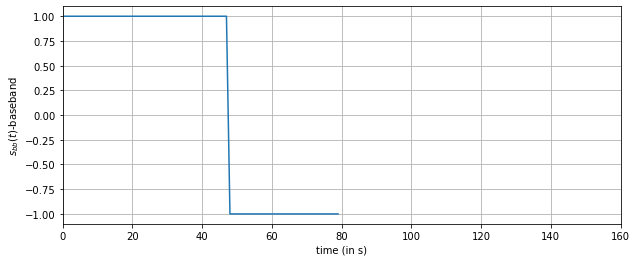

In [13]:
#Execute in Python3: exec(open("chapter_2/bpsk.py").read())
import numpy as np #for numerical computing
import matplotlib.pyplot as plt #for plotting functions
#from DigiCommPy.passband_modulations import bpsk_mod, bpsk_demod
#from DigiCommPy.channels import awgn
from scipy.special import erfc


def bpsk_mod(ak,L):
    from scipy.signal import upfirdn
    s_bb = upfirdn(h=[1]*L, x=2*ak-1, up = L) # NRZ encoder
    t=np.arange(start = 0,stop = len(ak)*L) #discrete time base
    return (s_bb,t)


N=5 # Number of symbols to transmit
EbN0dB = np.arange(start=-4,stop = 11,step = 2) # Eb/N0 range in dB for simulation
L=16 # oversampling factor,L=Tb/Ts(Tb=bit period,Ts=sampling period)
# if a carrier is used, use L = Fs/Fc, where Fs >> 2xFc
#Fc=900e-6 # carrier frequency

#----Choose 1 channel between channel 1 (900MHz), 2(910MHz), 3(920MHz) or 4(930MHz)---
deltaf = 10e6
Fc = 900e6 #900MHz
k = np.random.randint(low=1, high = 5) #channel is decided randomly
d_k = k-1
h_k = Fc + (d_k*deltaf)
print('AP uses channel '+str(k)+' having frequency '+str(h_k))

Fs=L*Fc # sampling frequency
BER = np.zeros(len(EbN0dB)) # for BER values for each Eb/N0
ak = np.random.randint(2, size=N) # uniform random symbols from 0's and 1's
(s_bb,t)= bpsk_mod(ak,L) # BPSK modulation(waveform) - baseband



# Waveforms at the transmitter
#plotting the baseband signal
plt.figure(figsize=(10, 4))
plt.plot(t,s_bb) # baseband wfm zoomed to first 10 bits
plt.xlabel('time (in s)')
plt.xlim(0,10*L);
plt.ylabel(r'$s_{bb}(t)$-baseband')
plt.grid(True)
plt.show()


In [14]:
print(ak)

[1 1 1 0 0]


(-2.0, 2.0)

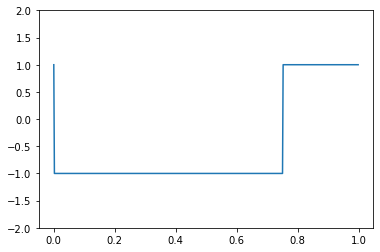

In [45]:
import numpy as np
from scipy import signal
import matplotlib.pyplot as plt
t = np.linspace(0, 1, 500, endpoint=False) #A 5 Hz waveform sampled at 500 Hz for 1s
plt.plot(t, signal.square(-1*(2 * np.pi * 1 * t), duty=0.25)) #A 5 Hz waveform for 1s creating 5 cycles in 1s
plt.ylim(-2, 2)

In [37]:
x=signal.square((2 * np.pi * 1 * t), duty=0.25)
x

array([ 1., -1., -1., -1., -1., -1., -1.,  1., -1., -1.,  1., -1., -1.,
        1., -1., -1.,  1., -1., -1.,  1., -1., -1.,  1., -1., -1.,  1.,
       -1., -1., -1., -1., -1., -1.,  1., -1., -1.,  1., -1., -1.,  1.,
       -1., -1.,  1., -1., -1.,  1., -1., -1.,  1., -1., -1.,  1., -1.,
       -1., -1., -1., -1., -1.,  1., -1., -1.,  1., -1., -1.,  1., -1.,
       -1.,  1., -1., -1.,  1., -1., -1.,  1., -1., -1.,  1., -1., -1.,
       -1., -1., -1., -1.,  1., -1., -1.,  1., -1., -1.,  1., -1., -1.,
        1., -1., -1.,  1., -1., -1.,  1., -1., -1.,  1., -1., -1., -1.,
       -1., -1., -1.,  1., -1., -1.,  1., -1., -1.,  1., -1., -1.,  1.,
       -1., -1.,  1., -1., -1.,  1., -1., -1.,  1., -1., -1., -1., -1.,
       -1., -1.,  1., -1., -1.,  1., -1., -1.,  1., -1., -1.,  1., -1.,
       -1.,  1., -1., -1.,  1., -1., -1.,  1., -1., -1., -1., -1., -1.,
       -1.,  1., -1., -1.,  1., -1., -1.,  1., -1., -1.,  1., -1., -1.,
        1., -1., -1.,  1., -1., -1.,  1., -1., -1., -1., -1., -1

In [35]:
print(np.arange(-3, 3, 0.5))

[-3.  -2.5 -2.  -1.5 -1.  -0.5  0.   0.5  1.   1.5  2.   2.5]


In [51]:
import math
#rewards
R_b = 10e3 #10kbps - tag transmits with a fixed data rate R_b
τ = 1
C = np.zeros(8)
rewards = np.zeros(8)
rewards_all_episodes = []
BER = np.array([3.6003e-01, 2.9812e-01, 2.1573e-01, 1.2898e-01, 5.8690e-02, 1.6520e-02, 2.3000e-03, 1.2000e-04])
for j in range(len(BER)):
    C[j] = 1 + BER[j]*math.log(BER[j]) + (1 - BER[j])*math.log(1 - BER[j])
    rewards[j] = R_b*C[j]*τ
rewards_all_episodes.append(rewards)
print(rewards_all_episodes)

[array([3465.64546235, 3907.37043247, 4785.49809605, 6155.56881391,
       7766.52307218, 9158.32621282, 9837.30500871, 9987.96644942])]
